In [1]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import clip
from PIL import Image
from tqdm import tqdm
import functions as fnc
from importlib import reload
from sklearn.cluster import KMeans
from scipy.ndimage import rotate
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms
from sklearn.neighbors import KDTree

In [2]:
OutDIR='/DATA/vito/output/'
DataDIR='/DATA/vito/data/'
MODEL_TYPE = "vit_h"

if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    print('Currently running on GPU\nModel '+MODEL_TYPE)
else:
    DEVICE = torch.device('cpu')
    print('Currently running on CPU\nModel '+MODEL_TYPE)

if MODEL_TYPE == 'vit_h':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_h_4b8939.pth'
elif MODEL_TYPE == 'vit_l':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_l_0b3195.pth'
else:
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_b_01ec64.pth'

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

Currently running on GPU
Model vit_h


In [7]:
test_outputs=np.load('/DATA/vito/output/colour_test/collect_test0_80.npy', allow_pickle=True).tolist()

In [8]:
for run in range(50):
    inner=True#False
    var=True#False

    #create image and noise
    all_col=[]
    all_col_mask=[]
    label=1
    for r in [4,6,8,10]:
        temp_row=[]
        temp_row_mask=[]
        for std in [0,10,25,40]:
            mask=fnc.make_circle(r)
            rgb_sphere=np.zeros((256,256,3))#fnc.circle_colouring(mask)
            if inner:
                if var:
                    std_edge=std/2
                    noisy_image=fnc.add_guassian_noise_to_circle(rgb_sphere,0,std,mask,std_edge)
                else:
                    noisy_image=fnc.add_guassian_noise_to_circle(rgb_sphere,0,std,mask)
            else:
                noisy_image=fnc.add_guassian_noise_to_circle(rgb_sphere,0,std)
            temp_row.append(noisy_image)
            temp_row_mask.append((mask).astype(int)*label)
            label+=1
        all_col.append(np.vstack(temp_row))
        all_col_mask.append(np.vstack(temp_row_mask))
    noise_layer=np.hstack(all_col)
    all_mask=np.hstack(all_col_mask)
    image, RGB, RGB_edge=fnc.circle_colouring(all_mask!=0)
    image=image+noise_layer

    #calculate color contrast
    RGB_nor=fnc.normalize_rgb(RGB)
    RGB_edge_nor=fnc.normalize_rgb(RGB_edge)

    ad=fnc.angular_distance(RGB_nor,RGB_edge_nor)
    ed=fnc.euclidean_distance(RGB,RGB_edge)

    #apply guassian filter
    xl=[1,3,5,7,9,11,13,15,17,19,21]
    All_nearest_iou=[]
    All_max_iou=[]
    for k in xl:
        temp_image=fnc.preprocessing_roulette(image, 
                                            {#'Crop': {'crop size': 1024, 'j':0},
                                                'Gaussian': {'kernel size':k},
                                                #'CLAHE':{'clip limit':3}#,
                                                # #'Downsample': {'fxy':4}
                                                })
        gc.collect()
        torch.cuda.empty_cache()

        mask_generator = SamAutomaticMaskGenerator(
            model=sam,
            points_per_side=12,
            pred_iou_thresh=0,
            stability_score_thresh=0,#iou by varying cutoff in binary conversion
            box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
            crop_n_layers=0,#cut into 2**n crops
            crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
            crop_n_points_downscale_factor=1,
            crop_overlap_ratio=0,
            #min_mask_region_area=2000,
        )
        with torch.no_grad():
            masks = mask_generator.generate(temp_image)
        #logit_scale=1000

        #prep selection
        seg_labels=(np.unique(all_mask)[1:])

        seg_size=[]
        for seg in seg_labels:
            seg_size.append(np.sum(all_mask==seg))

        seg_size_sort_idx=np.argsort(seg_size)

        list_of_label=[(all_mask==seg_labels[index]).astype(np.uint8) for index in seg_size_sort_idx]
        ar_label=np.stack(list_of_label)

        list_of_masks = [fnc.clean_mask(mask['segmentation'].astype(np.uint8)) for mask in masks]#remove small disconnected parts
        ar_masks=np.stack(list_of_masks)

        ar_all=np.stack(list_of_label+list_of_masks)
        list_of_centroid = [fnc.get_centroid(ar_all[i]) for i in range(len(ar_all))]
        ar_all.shape

        ar_all_flat=ar_all.reshape((ar_all.shape[0],ar_all.shape[1]*ar_all.shape[2]))
        set_overlap = set()

        # Iterate through each column of the array
        for i in range(ar_all_flat.shape[1]):
            # for each pixel find out the idex of mask where the pixel was in a mask
            nz = np.where(ar_all_flat[:, i] != 0)[0]
            
            # if there are overlap of mask
            if len(nz) > 1:
                nz_tuple = tuple(nz)
                set_overlap.add(nz_tuple)

        list_overlap = list(set_overlap)

        #centroid based selection
        tree = KDTree(list_of_centroid)              
        k=10
        _, ind = tree.query(list_of_centroid[:len(list_of_label)], k=k)

        # get nearest centroid iou
        kdc_iou=[]
        nearest_mask_pick=[]
        for match in ind:
            #check if nearest neighbor is not a label
            j=1
            while match[j]<len(list_of_label):
                j+=1
            if j<k:
                kdc_iou.append(fnc.iou(ar_all[match[0]],ar_all[match[j]]))
                nearest_mask_pick.append(match[j])
            else:
                kdc_iou.append(-0.1)

            
        # get all average and max iou
        overlap_by_label=[]
        max_iou=[]
        max_mask_pick=[]
        for i in range(len(list_of_label)):
            all_pairs=[tup for tup in list_overlap if i in tup]
            if len(all_pairs)>0:
                overlap_with_i=np.unique(np.hstack(all_pairs))[1:]
                overlap_by_label.append(overlap_with_i)
                agg_iou=[]
                for j in overlap_with_i:
                    agg_iou.append(fnc.iou(ar_label[i],ar_masks[j-len(list_of_label)]))
                max_iou.append(np.max(agg_iou))
                max_mask_pick.append(overlap_with_i[np.argmax(agg_iou)])
            else:
                overlap_by_label.append(np.array([]))
                max_iou.append(-0.1)
        All_nearest_iou.append(kdc_iou)
        All_max_iou.append(max_iou)
    All_nearest_iou=np.array(All_nearest_iou)
    All_max_iou=np.array(All_max_iou)
    output={'RGB':RGB, 'RGB_edge':RGB_edge, 
            'angular_distance': ad, 'euclidean_distance':ed, 
            'All_max_iou': All_max_iou, 'All_nearest_iou':All_nearest_iou}
    test_outputs.append(output)
    np.save(f'/DATA/vito/output/colour_test/test{run+80:03}.npy',output)


In [9]:
np.save(f'/DATA/vito/output/colour_test/collect_test0_130.npy',test_outputs)

In [6]:
test_outputs=np.load('/DATA/vito/output/colour_test/collect_test0_80.npy', allow_pickle=True).tolist()

81

In [10]:
max_iou=[out['All_max_iou'] for out in test_outputs]
nearest_iou=[out['All_nearest_iou'] for out in test_outputs]
angular=np.array([out['angular_distance'] for out in test_outputs])
euclidean=np.array([out['euclidean_distance'] for out in test_outputs])

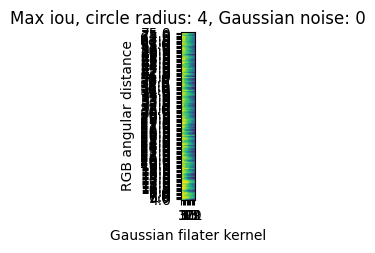

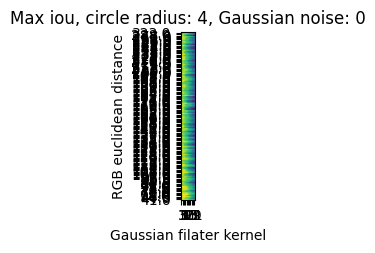

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 4, 1)
plt.title(f'Max iou, circle radius: 4, Gaussian noise: 0')#{radi[i]}')
plt.imshow(np.vstack([max_iou[arg][:,0] for arg in np.argsort(angular)]), origin='lower')
plt.yticks(np.arange(len(angular)), np.round(np.sort(angular)))
plt.ylabel('RGB angular distance')
plt.xticks(range(len(max_iou[0][:,1])), xl)
plt.xlabel('Gaussian filater kernel')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(4, 4, 1)
plt.title(f'Max iou, circle radius: 4, Gaussian noise: 0')#{radi[i]}')
plt.imshow(np.vstack([max_iou[arg][:,0] for arg in np.argsort(euclidean)]), origin='lower')
plt.yticks(np.arange(len(euclidean)), np.round(np.sort(euclidean)))
plt.ylabel('RGB euclidean distance')
plt.xticks(range(len(max_iou[0][:,1])), xl)
plt.xlabel('Gaussian filater kernel')
plt.show()

In [12]:
scatter_min=np.percentile(np.array(max_iou)[:,:,0],25)
scatter_max=np.percentile(np.array(max_iou)[:,:,0],75)

/DATA/vito/.venv/lib/python3.8/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


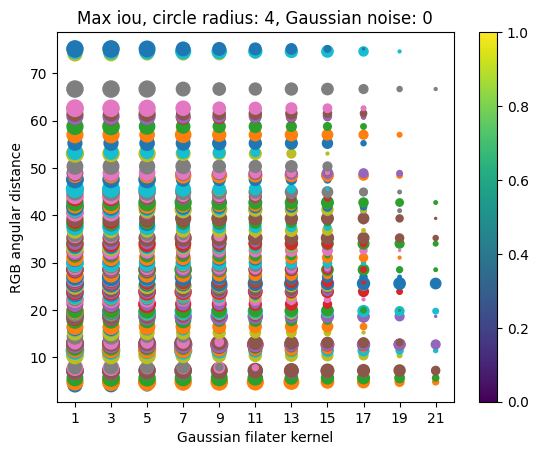

In [13]:
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 4, 1)
plt.title(f'Max iou, circle radius: 4, Gaussian noise: 0')#{radi[i]}')
#y_boxs=int(np.max(angular))-int(np.min(angular))
#plot_array=np.zeros((y_boxs+1,len(max_iou[0][:,1])))
for arg in np.argsort(angular):
    #plot_array[int(angular[arg])-int(np.min(angular)),:]=max_iou[arg][:,0]
    plt.scatter(range(len(max_iou[0][:,0])),np.ones(len(max_iou[0][:,0]))*angular[arg]
                ,s=((max_iou[arg][:,0]-scatter_min)/(scatter_max-scatter_min))*100)
#plt.yticks(np.arange(len(angular)), np.sort(angular))
#plot_array[plot_array==0]=np.nan
#plt.imshow(plot_array, interpolation='nearest')
plt.ylabel('RGB angular distance')
plt.xticks(range(len(max_iou[0][:,1])), xl)
plt.xlabel('Gaussian filater kernel')
plt.colorbar()
plt.show()

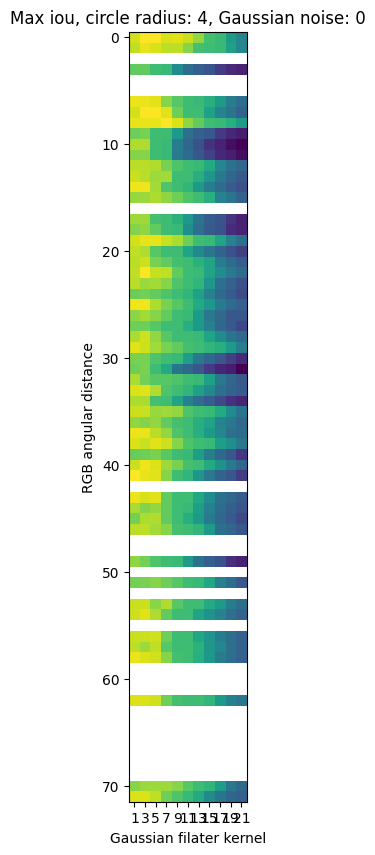

In [16]:
plt.figure(figsize=(5, 10))
#plt.subplot(4, 4, 1)
plt.title(f'Max iou, circle radius: 4, Gaussian noise: 0')#{radi[i]}')
y_boxs=int(np.max(angular))-int(np.min(angular))
plot_array=np.zeros((y_boxs+1,len(max_iou[0][:,1])))
for arg in np.argsort(angular):
    plot_array[int(angular[arg])-int(np.min(angular)),:]=max_iou[arg][:,0]
    #plt.scatter(range(len(max_iou[0][:,1])),np.ones(len(max_iou[0][:,1]))*angular[arg],c=max_iou[arg][:,1])
#plt.yticks(np.arange(len(angular)), np.sort(angular))
plot_array[plot_array==0]=np.nan
plt.imshow(plot_array, interpolation='nearest')
plt.ylabel('RGB angular distance')
plt.xticks(range(len(max_iou[0][:,1])), xl)
plt.xlabel('Gaussian filater kernel')
plt.show()

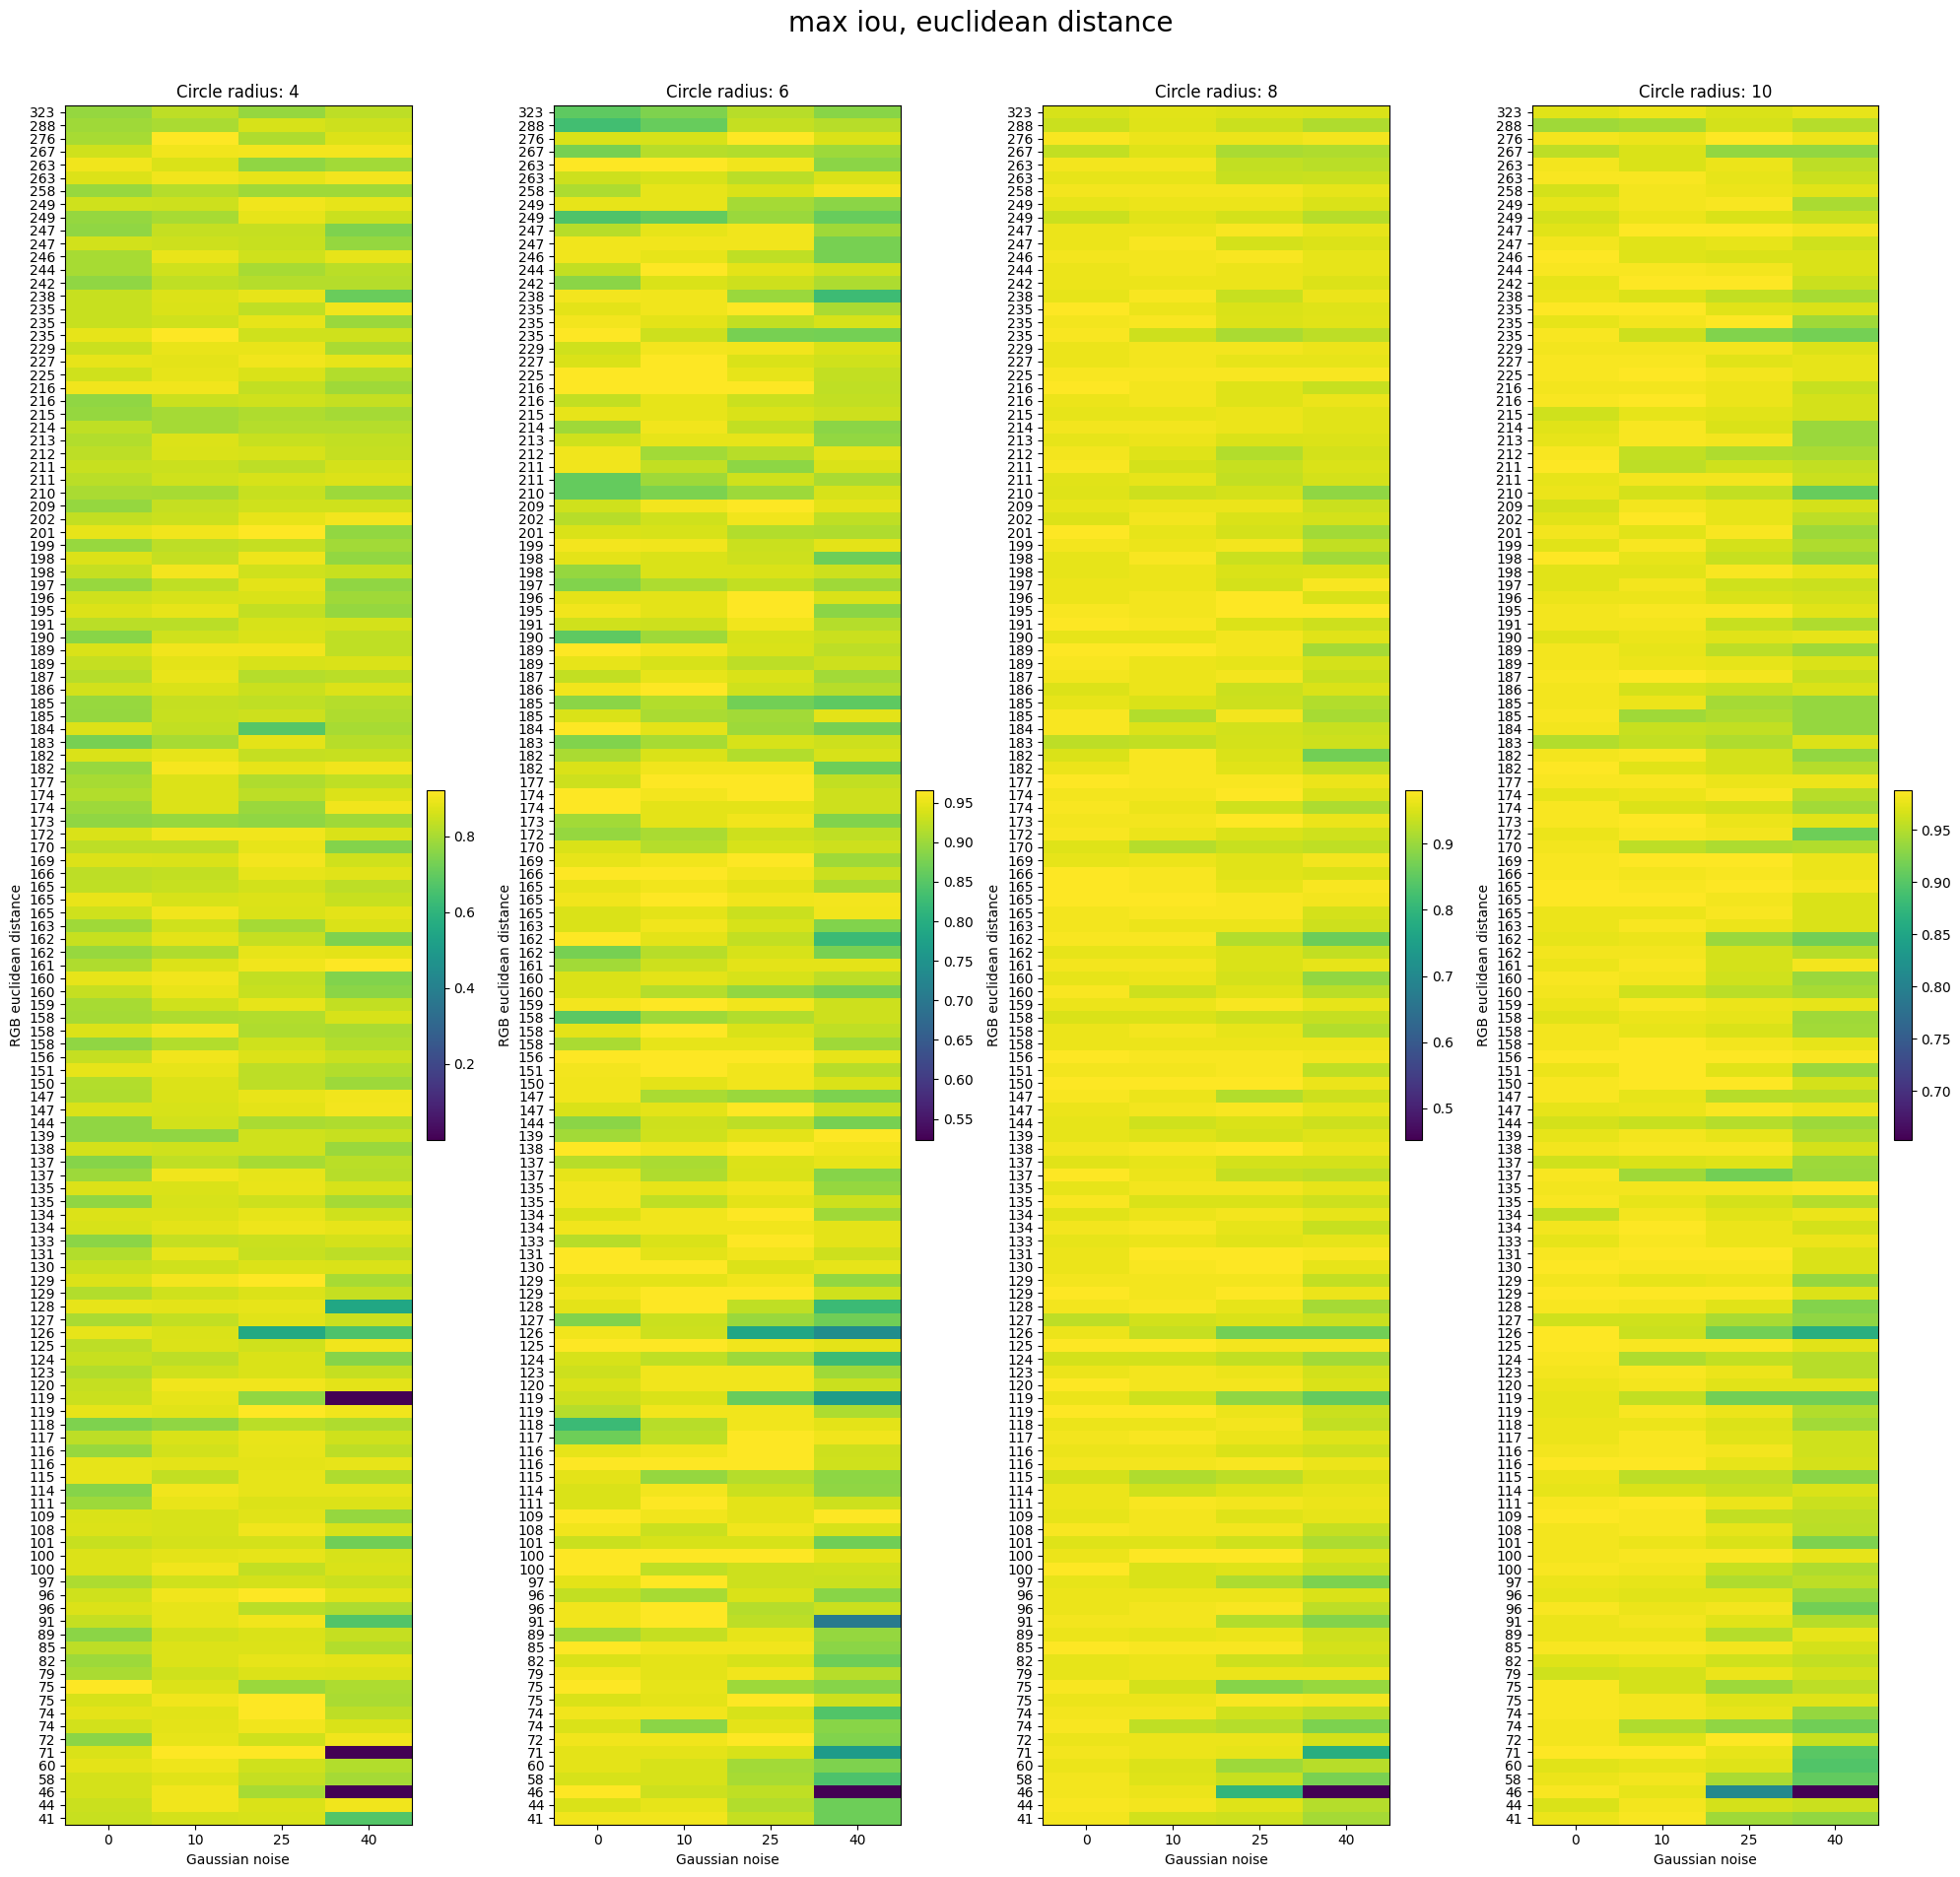

In [24]:
gn=[0,10,25,40]
radi=[4,6,8,10]
euclidean_sorted_id=np.argsort(euclidean)
yticks=np.arange(len(euclidean))
ylabels=np.round(np.sort(euclidean)).astype(int)
xticks=range(len(max_iou[0][:,1]))

plt.figure(figsize=(20, 20))
for i in range(4):#loop through radi
    size_fig=[]
    for j in range(4):#loop through noise level
        col=i*4+j
        #plt.subplot(1, 4, j+1)
        size_fig.append(np.vstack([max_iou[arg][:,col][0] for arg in euclidean_sorted_id]))
    
    plt.subplot(1, 4, i+1)
    plt.title(f'Circle radius: {radi[i]}')
    plt.imshow(np.hstack(size_fig), origin='lower', aspect='auto') 
#                vmax=1,vmin=0.3)
    plt.yticks(yticks, ylabels)
    plt.ylabel('RGB euclidean distance')
    plt.xticks(range(4), gn)
    plt.xlabel('Gaussian noise')
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('max iou, euclidean distance', fontsize=20)
plt.show()

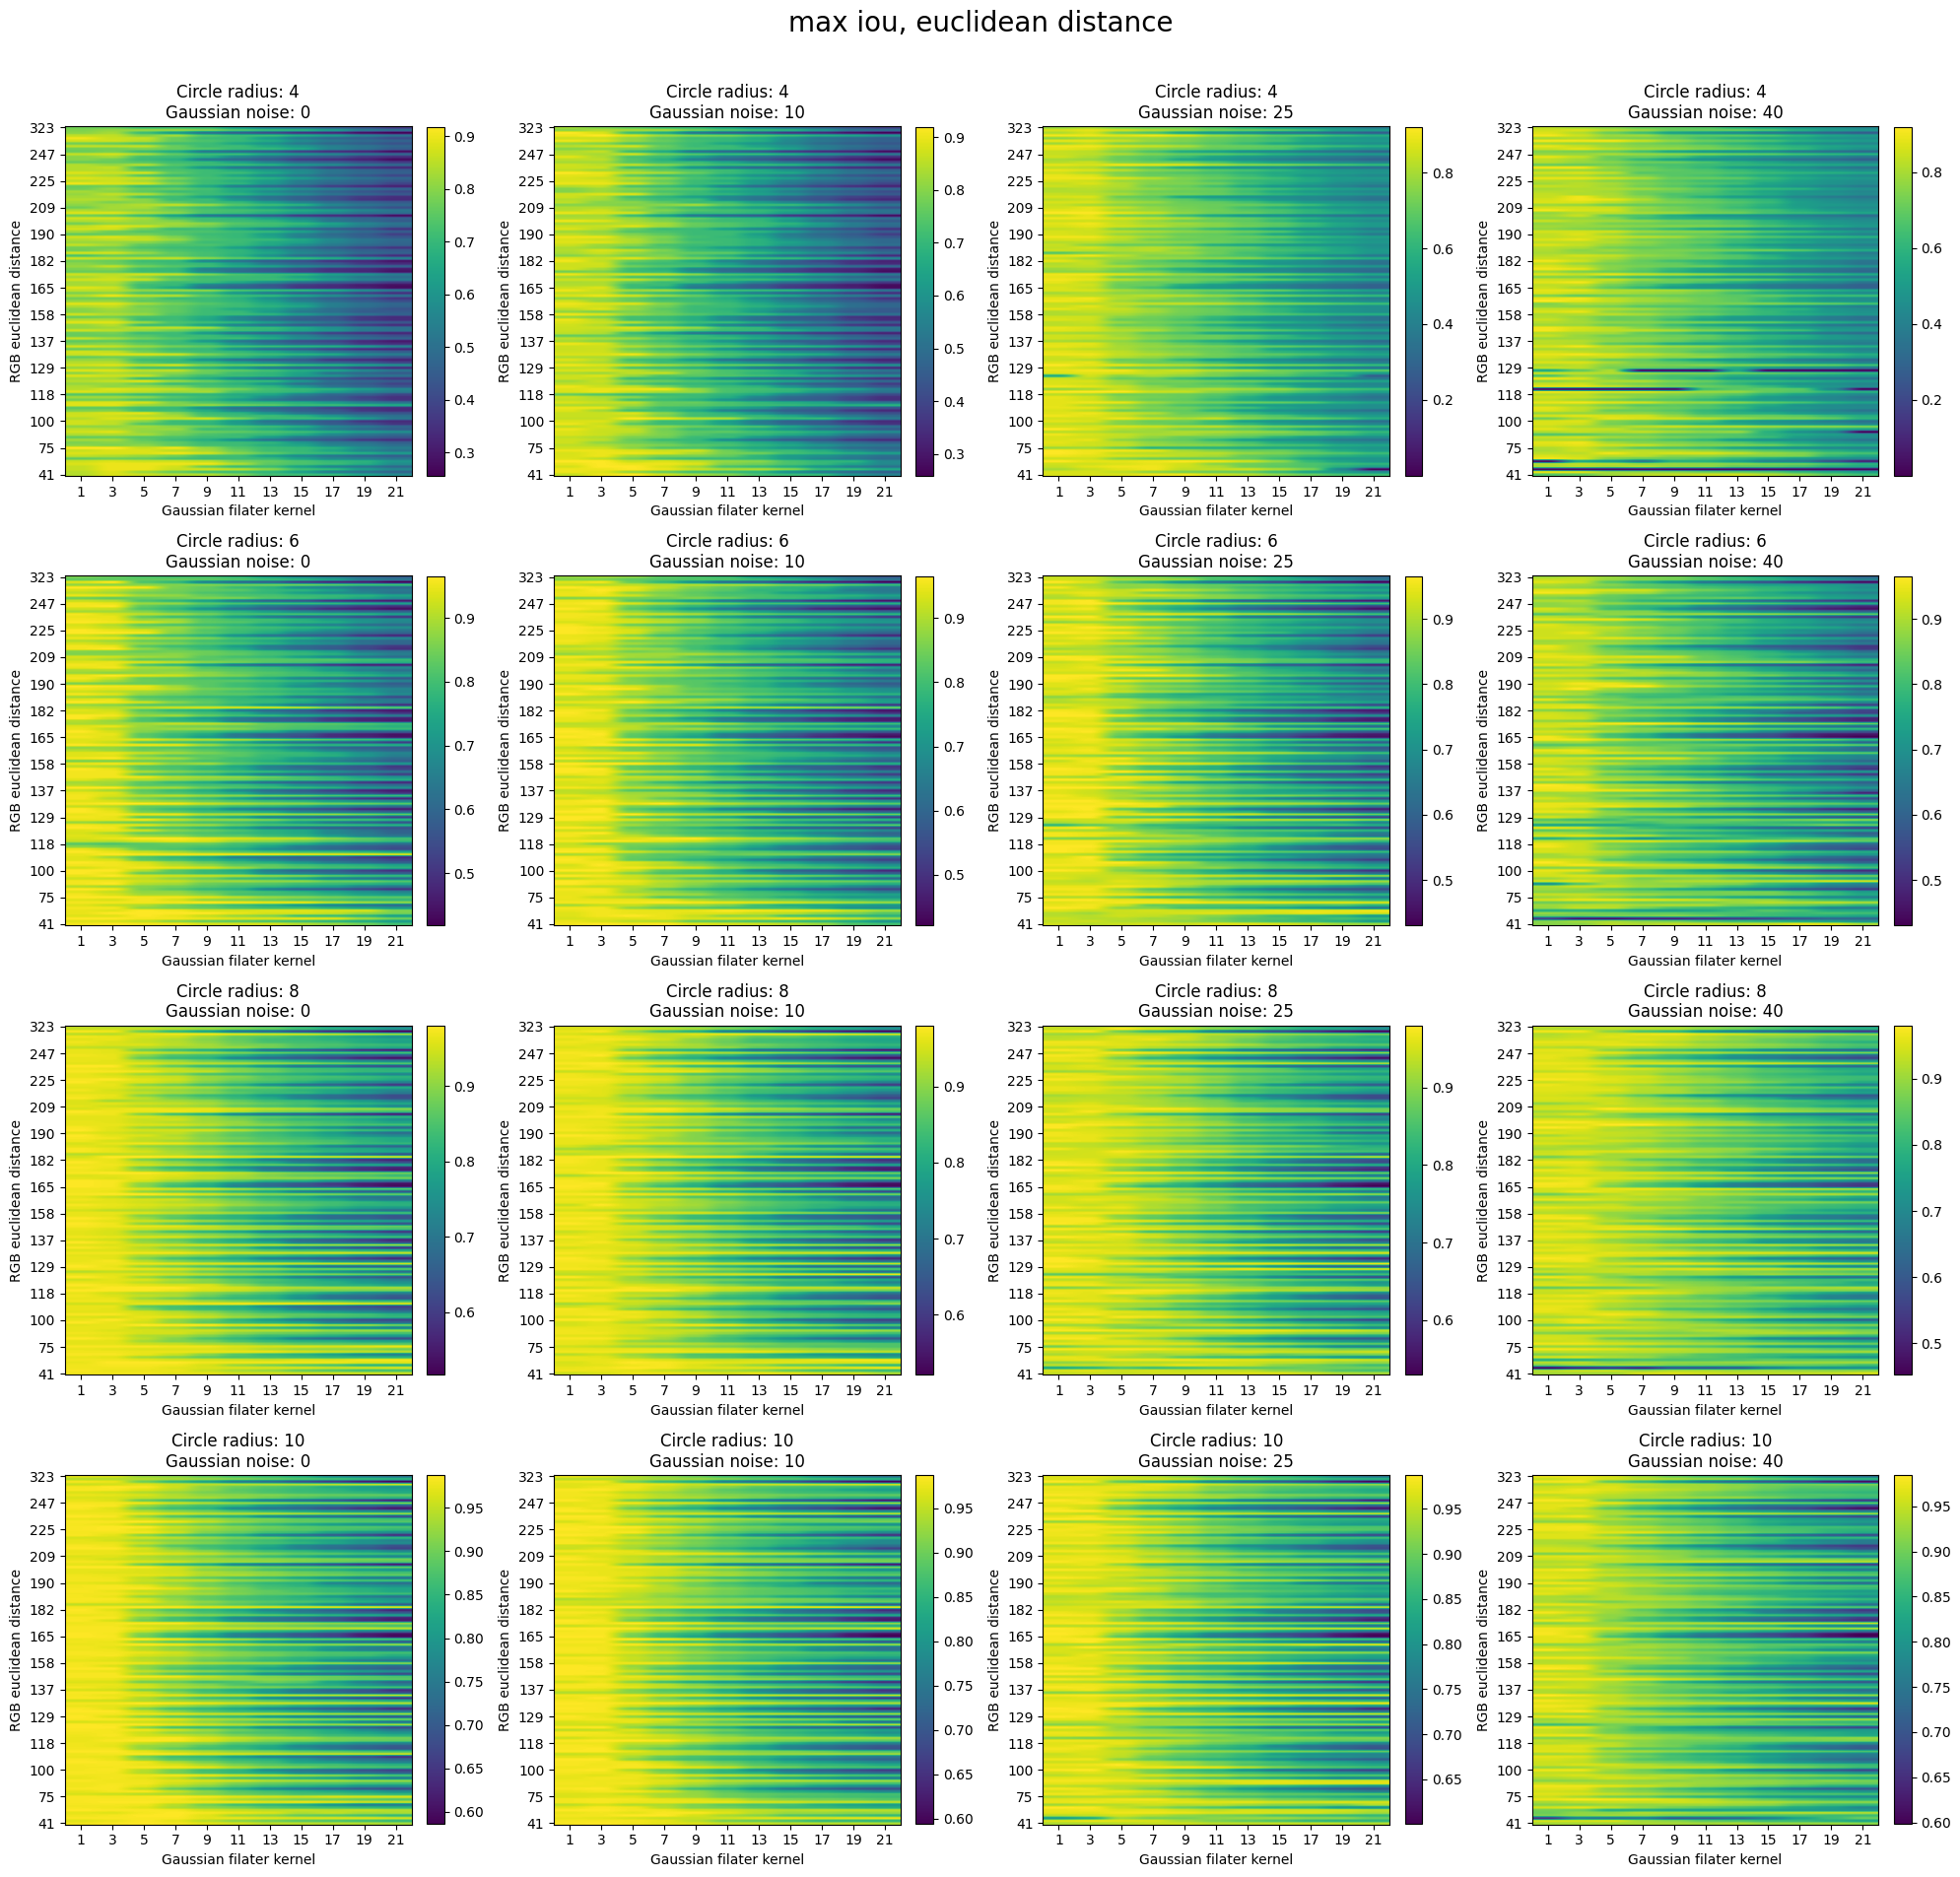

In [28]:
gn=[0,10,25,40]
radi=[4,6,8,10]
euclidean_sorted_id=np.argsort(euclidean)
yticks=np.arange(len(euclidean))
ylabels=np.round(np.sort(euclidean)).astype(int)
xticks=range(len(max_iou[0][:,1]))

plt.figure(figsize=(20, 20))
for i in range(4):#loop through radi
    #plt.figure(figsize=(15, 30))
    for j in range(4):#loop through noise level
        col=i*4+j
        #plt.subplot(1, 4, j+1)
        plt.subplot(4, 4, i*4+j+1)
        plt.title(f'Circle radius: {radi[i]}\nGaussian noise: {gn[j]}')
        plt.imshow(np.vstack([max_iou[arg][:,col] for arg in euclidean_sorted_id]), origin='lower', aspect='auto')
                    #, vmax=1,vmin=0.3, aspect='auto')
        plt.yticks(yticks[::10], ylabels[::10])
        plt.ylabel('RGB euclidean distance')
        plt.xticks(xticks, xl)
        plt.xlabel('Gaussian filater kernel')
        plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('max iou, euclidean distance', fontsize=20)
plt.show()

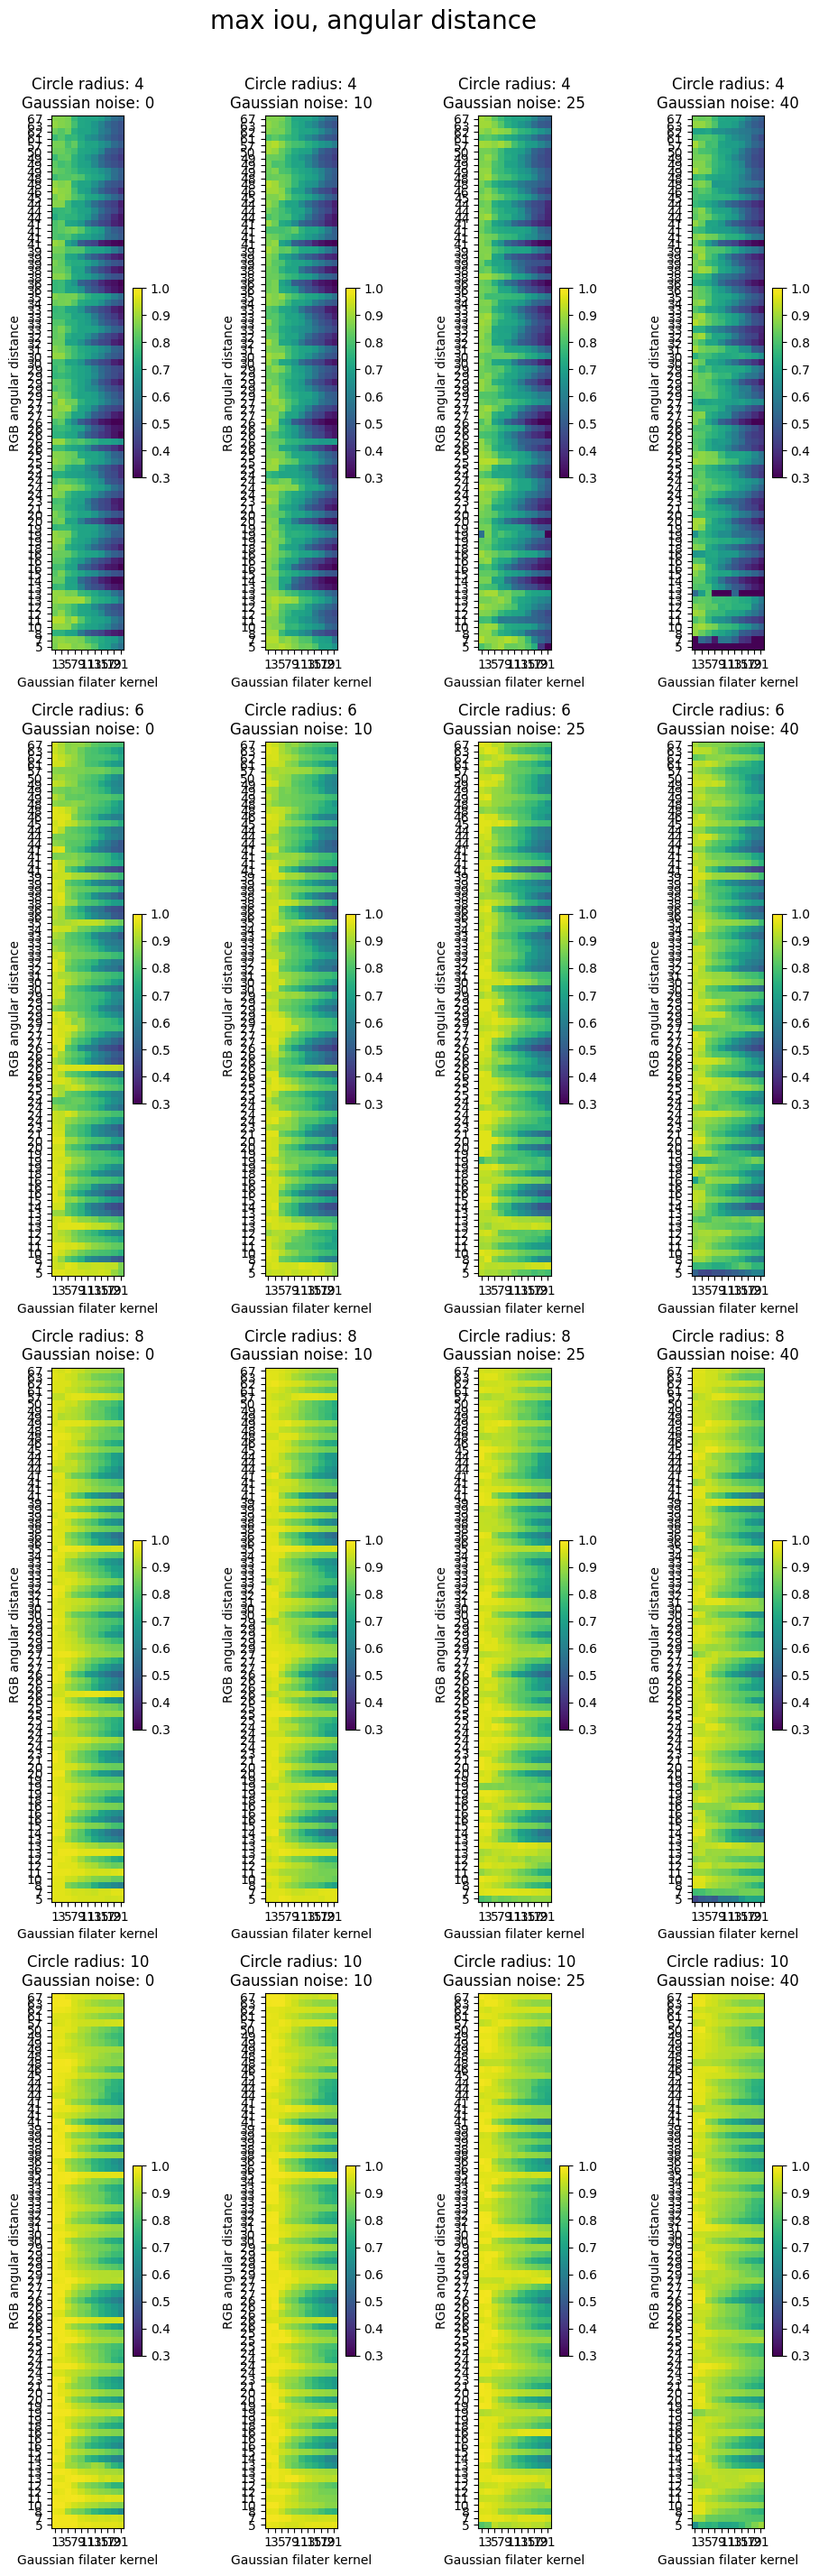

In [189]:
gn=[0,10,25,40]
radi=[4,6,8,10]
angular_sorted_id=np.argsort(angular)
yticks=np.arange(len(angular))
ylabels=np.round(np.sort(angular)).astype(int)
xticks=range(len(max_iou[0][:,1]))

plt.figure(figsize=(10, 30))
for i in range(4):#loop through radi
    
    for j in range(4):#loop through noise level
        col=i*4+j
        plt.subplot(4, 4, i*4+j+1)
        plt.title(f'Circle radius: {radi[i]}\nGaussian noise: {gn[j]}')
        plt.imshow(np.vstack([max_iou[arg][:,col] for arg in angular_sorted_id]), origin='lower', 
                   vmax=1,vmin=0.3)
        plt.yticks(yticks, ylabels)
        plt.ylabel('RGB angular distance')
        plt.xticks(xticks, xl)
        plt.xlabel('Gaussian filater kernel')
        plt.colorbar(fraction=0.046, pad=0.04)

        #plt.title(f'Max iou, circle radius: {radi[i]}')
        #plt.xticks(np.arange(4), [0,10,25,40])
        #plt.xlabel('Gaussian noise std')
        #plt.yticks(range(len(All_max_iou)), xl)
        #plt.ylabel('Gaussian kernel')
        #plt.imshow(np.array(All_max_iou)[:,col])#, vmin=0.3,vmax=1)
        #plt.colorbar(orientation='horizontal')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.suptitle('max iou, angular distance', fontsize=20)
plt.show()

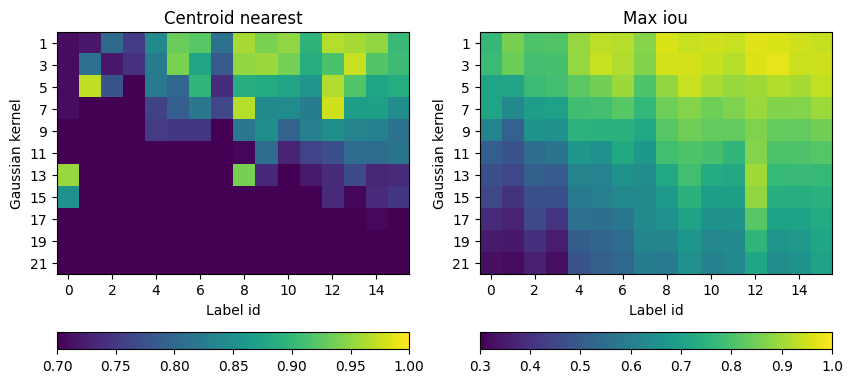

In [77]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Centroid nearest')
#plt.xticks(np.arange(4)*256+128, [4,16,32,128])
plt.xlabel('Label id')
plt.yticks(range(len(All_nearest_iou)), xl)
plt.ylabel('Gaussian kernel')
plt.imshow(All_nearest_iou, vmin=0.7,vmax=1)
plt.colorbar(orientation='horizontal')

plt.subplot(1, 2, 2)
plt.title('Max iou')
#plt.xticks(np.arange(4)*256+128, [4,16,32,128])
plt.xlabel('Label id')
plt.yticks(range(len(All_max_iou)), xl)
plt.ylabel('Gaussian kernel')
plt.imshow(All_max_iou, vmin=0.3,vmax=1)
plt.colorbar(orientation='horizontal')

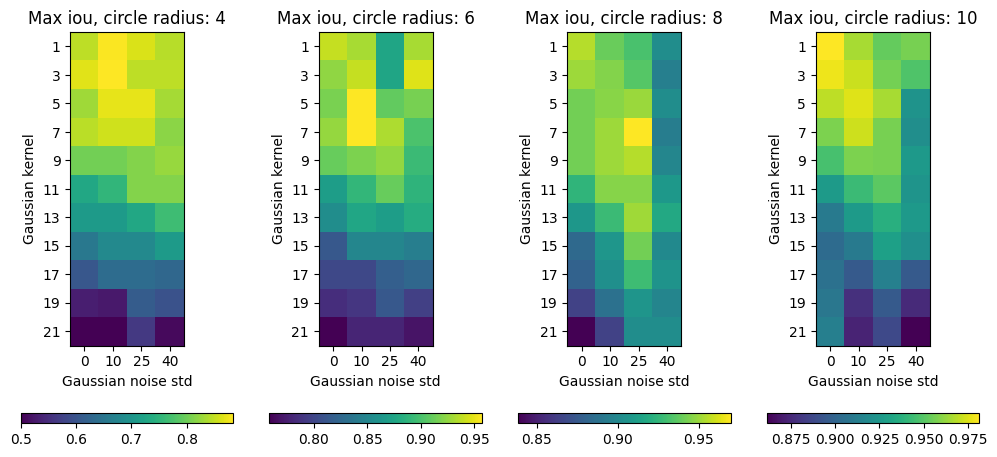

In [38]:
radi=[4,6,8,10]
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.title(f'Max iou, circle radius: {radi[i]}')
    plt.xticks(np.arange(4), [0,10,25,40])
    plt.xlabel('Gaussian noise std')
    plt.yticks(range(len(All_max_iou)), xl)
    plt.ylabel('Gaussian kernel')
    plt.imshow(np.array(All_max_iou)[:,i*4:(i+1)*4])#, vmin=0.3,vmax=1)
    plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

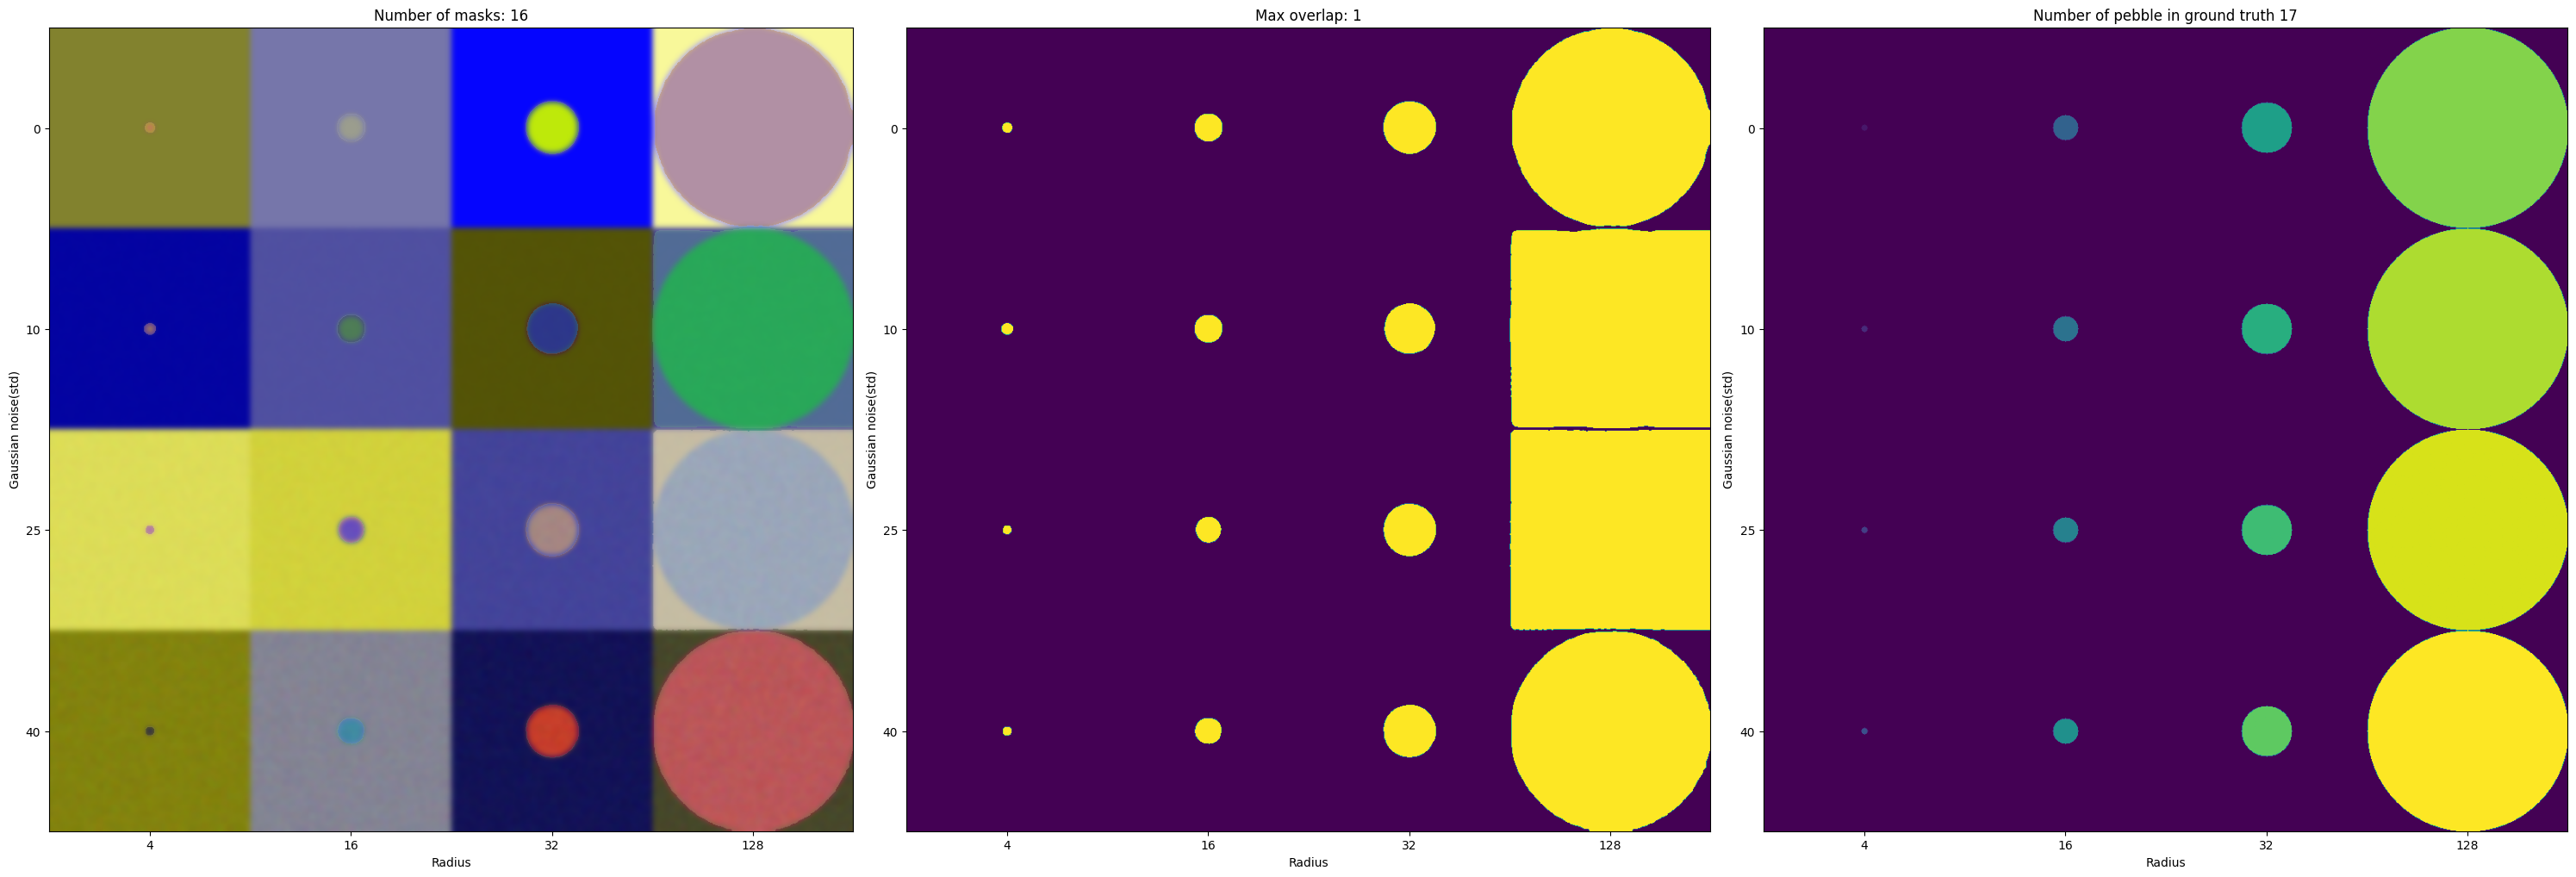

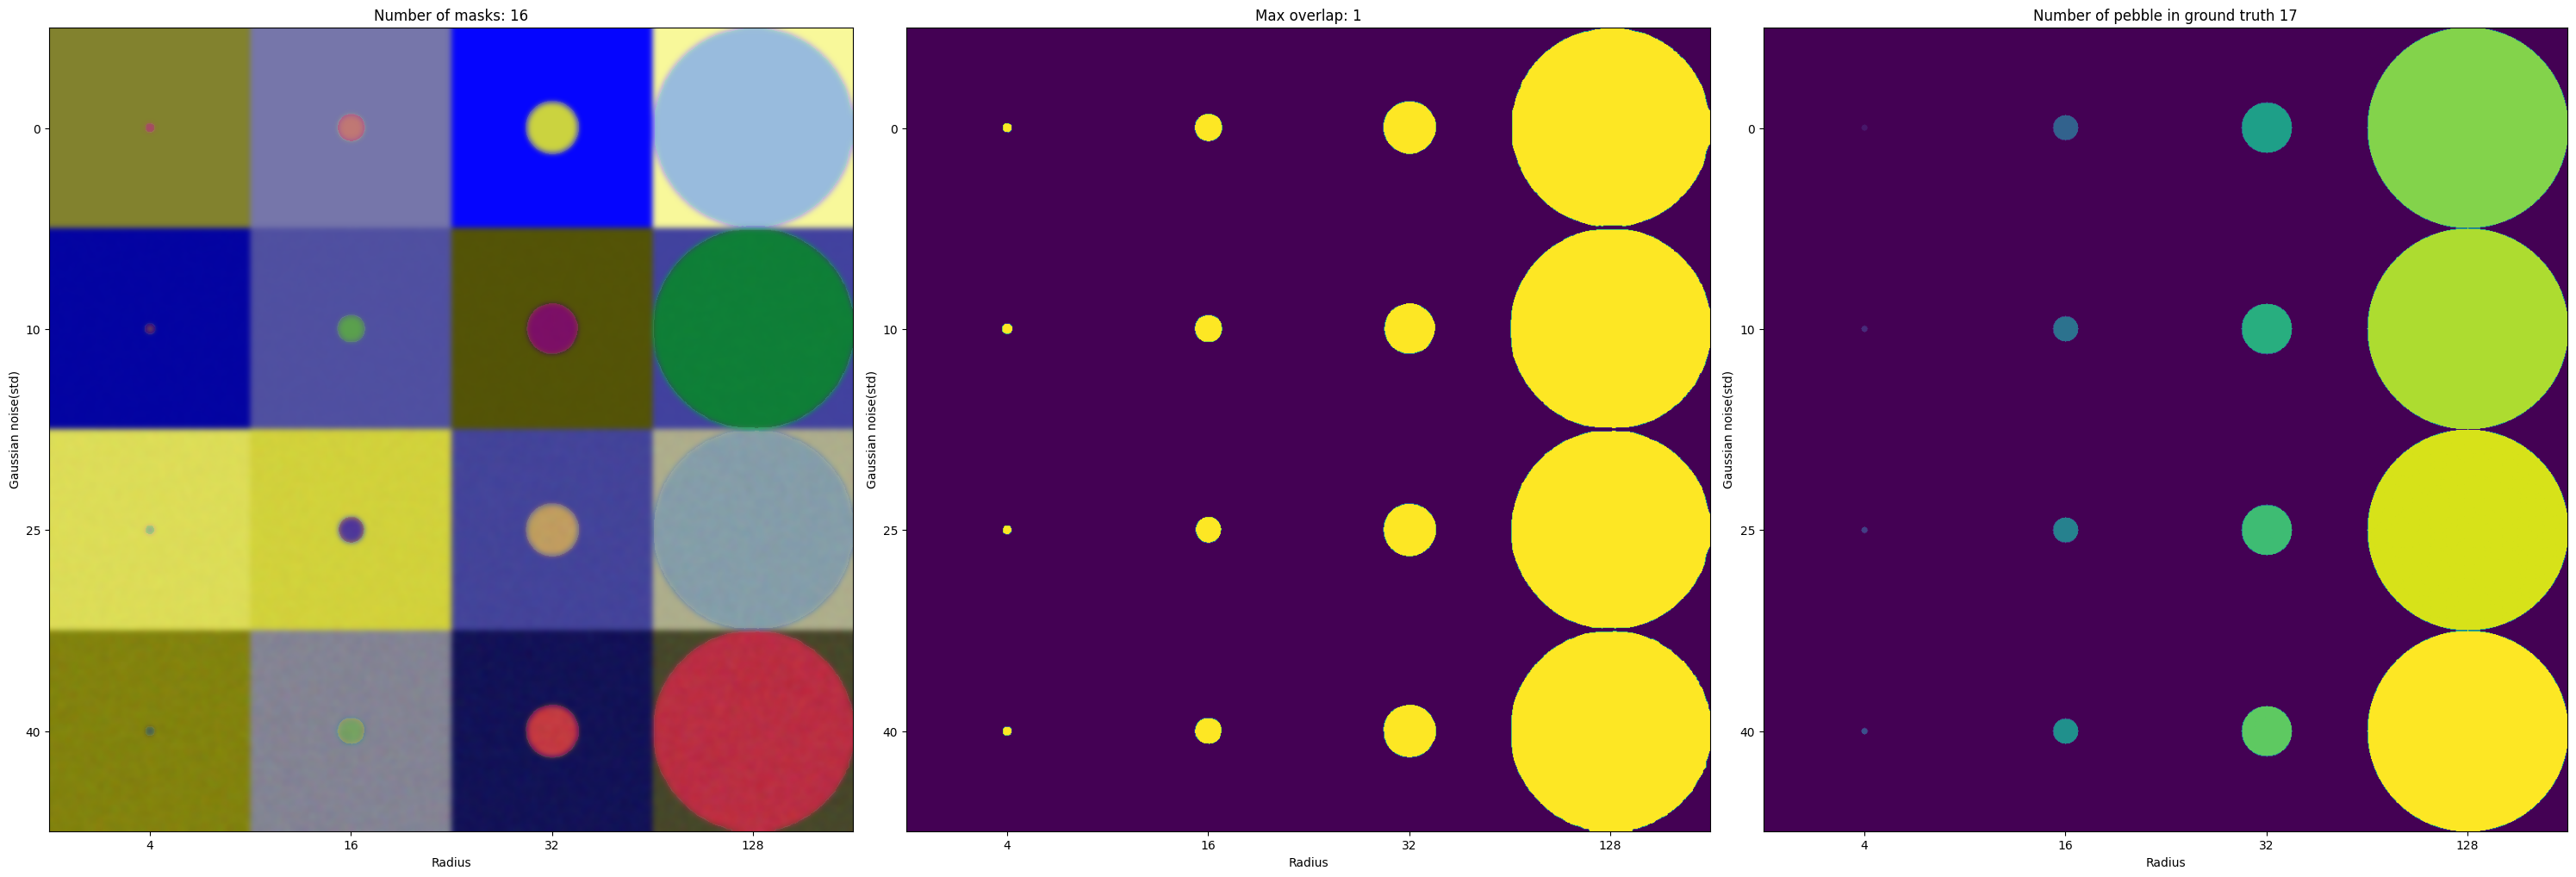

In [87]:
for t_masks in [nearest_subset_masks,max_subset_masks]:
    fig, ax = plt.subplots(1,3,figsize=(30,20))
    ax=ax.flatten()
    i=0
    ax[i*2].imshow(temp_image)
    fnc.show_anns_mod_ax(t_masks, ax[i*2], label=None, sort=False)
    #ax[i*2].axis('off')
    ax[i*2].set_title(f'Number of masks: {len(t_masks)}')
    ax[i*2].set_xticks(np.arange(4)*256+128, [4,16,32,128])
    ax[i*2].set_xlabel('Radius')
    ax[i*2].set_yticks(np.arange(4)*256+128, [0,10,25,40])
    ax[i*2].set_ylabel('Gaussian noise(std)')

    list_of_masks = [mask['segmentation'].astype(np.uint8) for mask in t_masks]
    ar_masks=np.stack(list_of_masks) 
    ax[i*2+1].imshow(np.sum(ar_masks,axis=0))
    ax[i*2+1].set_title(f'Max overlap: {np.unique(np.sum(ar_masks,axis=0)).max()}')  
    ax[i*2+1].set_xticks(np.arange(4)*256+128, [4,16,32,128])
    ax[i*2+1].set_xlabel('Radius')
    ax[i*2+1].set_yticks(np.arange(4)*256+128, [0,10,25,40])
    ax[i*2+1].set_ylabel('Gaussian noise(std)')

    ax[i*2+2].imshow(all_mask)  
    ax[i*2+2].set_title(f'Number of pebble in ground truth {len(np.unique(all_mask))}')   
    ax[i*2+2].set_xticks(np.arange(4)*256+128, [4,16,32,128])
    ax[i*2+2].set_xlabel('Radius')
    ax[i*2+2].set_yticks(np.arange(4)*256+128, [0,10,25,40])
    ax[i*2+2].set_ylabel('Gaussian noise(std)')

    plt.tight_layout()
    plt.show()

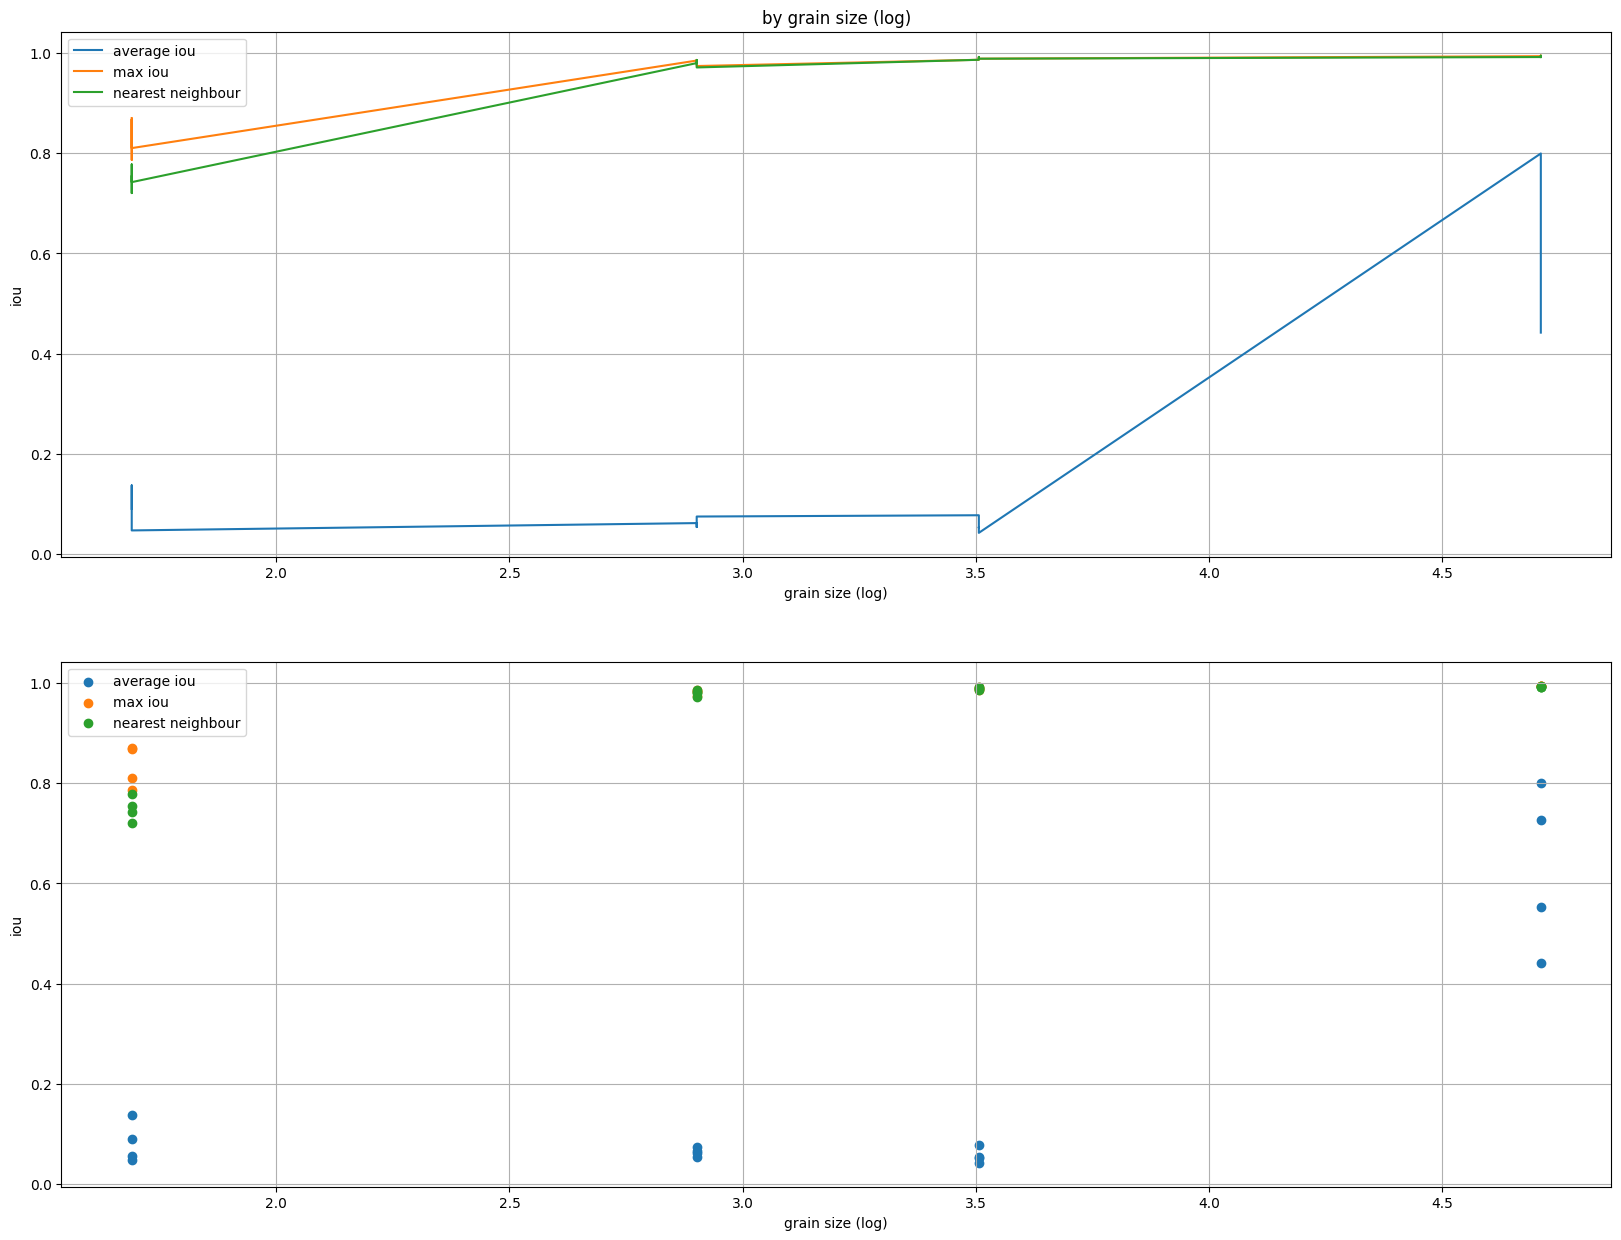

In [82]:
fig,ax=plt.subplots(2,1,figsize=(20,15))
ax=ax.flatten()
ax[0].plot(np.log10([seg_size[i] for i in seg_size_sort_idx]),avg_iou,label='average iou')
ax[0].plot(np.log10([seg_size[i] for i in seg_size_sort_idx]),max_iou,label='max iou')
ax[0].plot(np.log10([seg_size[i] for i in seg_size_sort_idx]),kdc_iou,label='nearest neighbour')
ax[0].set_xlabel('grain size (log)')
ax[0].set_ylabel('iou')
ax[0].grid()
ax[0].legend()
ax[1].scatter(np.log10([seg_size[i] for i in seg_size_sort_idx]),avg_iou,label='average iou')
ax[1].scatter(np.log10([seg_size[i] for i in seg_size_sort_idx]),max_iou,label='max iou')
ax[1].scatter(np.log10([seg_size[i] for i in seg_size_sort_idx]),kdc_iou,label='nearest neighbour')
ax[1].set_xlabel('grain size (log)')
ax[1].set_ylabel('iou')
ax[1].grid()
ax[1].legend()
ax[0].set_title('by grain size (log)')
plt.show()

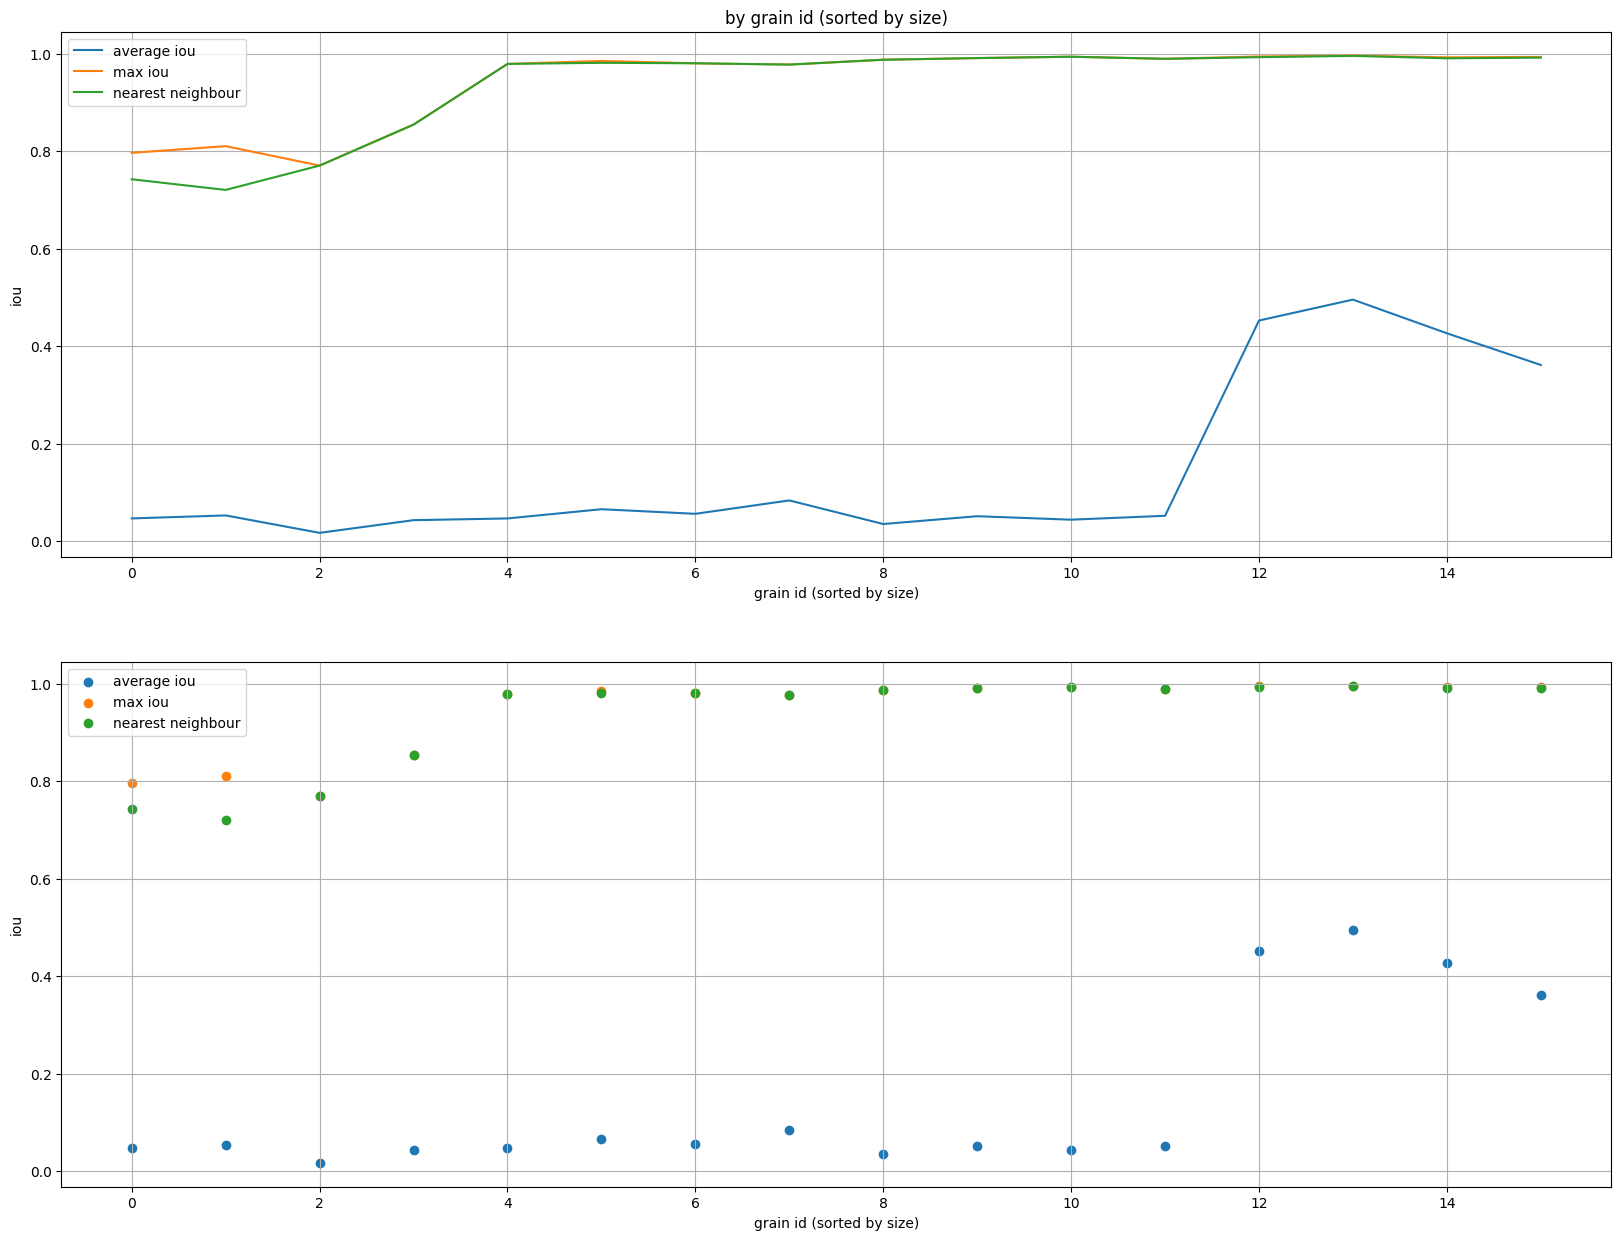

In [15]:
fig,ax=plt.subplots(2,1,figsize=(20,15))
ax=ax.flatten()
ax[0].plot(range(len(list_of_label)),avg_iou,label='average iou')
ax[0].plot(range(len(list_of_label)),max_iou,label='max iou')
ax[0].plot(range(len(list_of_label)),kdc_iou,label='nearest neighbour')
ax[0].set_xlabel('grain id (sorted by size)')
ax[0].set_ylabel('iou')
ax[0].grid()
ax[0].legend()
ax[1].scatter(range(len(list_of_label)),avg_iou,label='average iou')
ax[1].scatter(range(len(list_of_label)),max_iou,label='max iou')
ax[1].scatter(range(len(list_of_label)),kdc_iou,label='nearest neighbour')
ax[1].set_xlabel('grain id (sorted by size)')
ax[1].set_ylabel('iou')
ax[1].grid()
ax[1].legend()
ax[0].set_title('by grain id (sorted by size)')
plt.show()